<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/ROC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
import itertools
from imblearn.over_sampling import SMOTE

from scipy import interp

%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/ROCdf.csv", sep = ';')

df

,Marker,Diagnosis
0,19.396250,1
1,48.747631,1
2,30.151102,1
3,22.956150,1
4,8.329277,0
...,...,...
395,8.103378,0
396,7.645763,0
397,8.275276,0
398,12.014207,0


In [3]:

print(df.describe())

           Marker   Diagnosis
count  400.000000  400.000000
mean    23.417442    0.557500
std     17.276833    0.497305
min      1.640793    0.000000
25%     10.629317    0.000000
50%     19.375569    1.000000
75%     30.673917    1.000000
max     96.807676    1.000000


Text(0.5, 0, 'Marker')

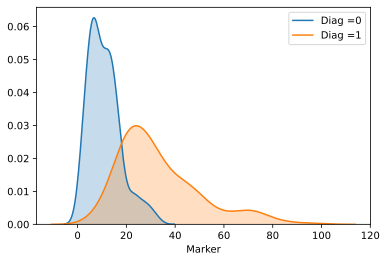

In [4]:
# explore dataset
for i in [0,1]:
    sns.kdeplot(df[df['Diagnosis']==i]['Marker'], shade = True, label = f'Diag ={i}')
plt.xlabel('Marker')

In [8]:
s = df[df['Diagnosis']== 1]
s.sum()

Marker       7417.717942
Diagnosis     223.000000
dtype: float64

In [9]:
df.Diagnosis.value_counts()

1    223
0    177
Name: Diagnosis, dtype: int64

#Xây dựng class ROC_analysis

In [15]:
class ROC_analysis:
    
    def __init__(self, X, Y):
        
        sm = SMOTE()
        X,Y = sm.fit_sample(X.values.reshape(-1, 1), Y)
        self.X, self.Y = pd.Series(X.ravel()),Y
    
    def binary_rule(self, thres = None):
        score = self.X
        lab_rule = {thres:1,0:0}
    
        def lab_mapping(value):
            for k, lab in lab_rule.items():
                if value >= k:
                    return lab

        pred = score.map(lab_mapping)

        return score, pred.values
    
    def cutoff_analysis(self, resolution = 1000, xmin = 0.1, crit = 'F1'):
        
        thres_list = np.linspace(xmin, self.X.max(), resolution)
        temp_perf = np.zeros(10)
        
        for t in thres_list:
        
            score, pred = self.binary_rule(thres = t)

            cnf_matrix = confusion_matrix(self.Y,pred)

            TN, FP, FN, TP = cnf_matrix.ravel()
            TPR=TP/(TP+FN)
            TNR=TN/(TN+FP)
            SEN=TPR
            SPEC=TNR
            Recall=SEN
            ACC=(TP+TN)/(TP+FP+TN+FN)
            PPV=TP/(TP+FP)
            NPV=TN/(TN+FN)
            LRpos=SEN/(1-SPEC)
            LRneg=(1-SEN)/SPEC
            J = SEN + SPEC - 1

            f1 = f1_score(self.Y, pred)
            bac = balanced_accuracy_score(self.Y, pred)
            
            temp_perf = np.vstack([temp_perf, [t, SEN, SPEC, f1, bac, PPV, NPV, LRpos, LRneg, J]])
        
        perf_df = pd.DataFrame(temp_perf).iloc[1:]
        perf_df.columns = ['Thres', 'Sen', 'Spec', 'F1', 'BAC', 'PPV', 'NPV', 'LRp', 'LRn', 'Youden_J']
        best_cut = perf_df[perf_df[crit] == perf_df[crit].max()]
        
        print(f'Xác định ngưỡng cắt tối ưu theo tiêu chí {crit}')
        
        self.best_cut = best_cut
        self.perf_df = perf_df
                    
        plt.rcParams.update({'font.size': 12})
        plt.figure(figsize=(10,6))
        plt.plot(thres_list[:-1], self.perf_df['Spec'][:-1], label="Độ đặc hiệu", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Sen'][:-1], label="Độ nhạy", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['F1'][:-1], label="Điểm F1", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['BAC'][:-1], label="Độ chính xác", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Youden_J'][:-1], label="Youden'J", linewidth=2)
        
        bc = self.best_cut['Thres'].values[0]
        plt.vlines(x = bc, 
                   ymin = 0.1, 
                   ymax = 1, 
                   colors = 'k', 
                   linestyles='dashed',
                  label = f'Ngưỡng tối ưu:{bc:.2f}')

        plt.xlabel("Thang đo", fontsize=15)
        plt.ylabel("Điểm số", fontsize=15)
        plt.legend(fontsize=12)
        plt.ylim([0.1, 1])
        plt.xlim([0.1, self.X.max()])
        
        return best_cut

    def Boot_ROCcurve(self,n_iter = 1000):
                    
        score, pred = self.binary_rule(thres = self.best_cut['Thres'].values[0])
        tprs = []
        aucs = []
        base_fpr = np.linspace(0, 1, 101)

        valid_df = pd.DataFrame({'Truth': self.Y,
                                 'Pred': pred,
                                 'Score': score})
                                #index = self.Y.index)

        for i in range(n_iter):
            resamp_df = valid_df.sample(1000, replace=True)

            if len(np.unique(resamp_df['Pred'])) < 2:
                continue

            fpr, tpr, _ = roc_curve(resamp_df['Truth'], resamp_df['Score'])

            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        mean_auc = auc(base_fpr, mean_tprs)
        std_auc = np.std(aucs)

        tprs_up = np.minimum(mean_tprs + 1.645*std, 1)
        tprs_low = mean_tprs - 1.645*std

        plt.rcParams["figure.figsize"] = (7,6.6)
        plt.rcParams.update({'font.size': 15})

        plt.plot(base_fpr, mean_tprs, 'r', 
                 alpha = 1, 
                 label=r'AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),)

        plt.fill_between(base_fpr, 
                         tprs_low, tprs_up, 
                         color = 'red', alpha = 0.3)

        plt.plot([0, 1], [0, 1], 
                 linestyle = '--', 
                 lw = 2, 
                 color = 'grey', 
                 label = 'Đoán ngẫu nhiên', 
                 alpha= 0.5)
        
        plt.vlines(x = 1 - self.best_cut['Spec'], 
                   ymin = 0., 
                   ymax = 1, 
                   colors = 'k', 
                   linestyles='dashed',)
        
        plt.hlines(y = self.best_cut['Sen'], 
                   xmin = 0., 
                   xmax = 1, 
                   colors = 'k', 
                   linestyles='dashed',)
        
        plt.plot(1 - self.best_cut['Spec'],
                 self.best_cut['Sen'], 
                 'ko')

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])

        plt.ylabel('Tỉ lệ dương tính thật')
        plt.xlabel('Tỉ lệ dương tính giả')
        plt.legend(loc="lower right")
        plt.title('Đường cong ROC')

In [16]:
r = ROC_analysis(df['Marker'], df['Diagnosis'])

Xác định ngưỡng cắt tối ưu theo tiêu chí F1


,Thres,Sen,Spec,F1,BAC,PPV,NPV,LRp,LRn,Youden_J
176,17.040784,0.914798,0.852018,0.886957,0.883408,0.860759,0.909091,6.181818,0.1,0.766816


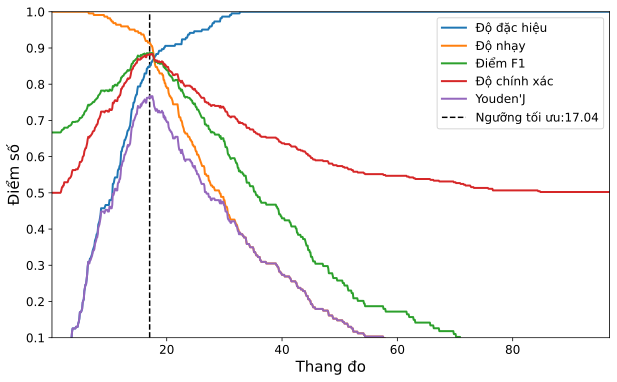

In [17]:
r.cutoff_analysis(resolution = 1000, xmin = 0.1, crit = 'F1')

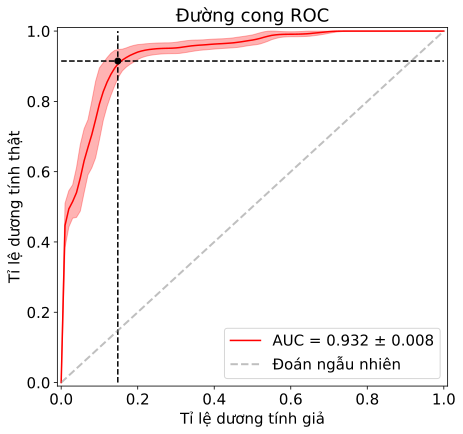

In [18]:
r.Boot_ROCcurve()